In [2]:
pip install git+https://github.com/uremes/elfi@extend_model

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/uremes/elfi (to revision extend_model) to /run/nvme/job_29338609/tmp/pip-req-build-j50g80mr
  Running command git clone --filter=blob:none --quiet https://github.com/uremes/elfi /run/nvme/job_29338609/tmp/pip-req-build-j50g80mr
  Running command git checkout -b extend_model --track origin/extend_model
  Switched to a new branch 'extend_model'
  branch 'extend_model' set up to track 'origin/extend_model'.
  Resolved https://github.com/uremes/elfi to commit 3b72621f57fb69b13053506942c20fcddda16963
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import elfi

In [5]:
import graphviz

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
seed = 20170530
np.random.seed(seed)

In [8]:
import simulator

In [9]:
pdic, t_samples, D = simulator.load()

In [10]:
para_true={'p': np.log10(pdic['p']),
 'beta': np.log10(pdic['beta']),
 'gamma': np.log10(pdic['gamma']),
 'prna': np.log10(pdic['prna']),
 'tauE': 7,
 'tauI': 41}

In [11]:
setup = pdic, t_samples, D   # base params, sample times, dilutions

In [12]:
def meanfield_simulator(gamma, p, beta, prna, tauE, tauI, setup, batch_size=1, random_state=None):

    pdic, t_samples, D = setup  # base params, sample times, dilutions

    pdic_para={'gamma': 10**gamma, 'p': 10**p, 'beta': 10**beta, 'prna': 10**prna, 'tauE': tauE, 'tauI': tauI}
    pdic.update(pdic_para)

    list_output = simulator.run(pdic, t_samples, D)
    return list_output

In [13]:
test_sim = meanfield_simulator(gamma=np.log10(pdic['gamma']), p=np.log10(pdic['p']), beta=np.log10(pdic['beta']), prna=np.log10(pdic['prna']), tauE=pdic['tauE'], tauI=pdic['tauI'], setup=setup, batch_size=1, random_state=None)

In [14]:
base = 'psimon-sH1N1/sH1N1_'
obs_dat_MC_ED = np.loadtxt(base+'MC_ED.dat')
obs_dat_MC_RNA = np.loadtxt(base+'MC_RNA.dat')
obs_dat_SC_ED = np.loadtxt(base+'SC_ED.dat')
obs_dat_SC_RNA = np.loadtxt(base+'SC_RNA.dat')
obs_dat_multi = obs_dat_MC_ED, obs_dat_MC_RNA, obs_dat_SC_ED, obs_dat_SC_RNA # the original multi sample experimental data

In [15]:
times_MC_ED, counts_MC_ED = np.unique(obs_dat_MC_ED[:, 0], return_counts=True)
times_SC_ED, counts_SC_ED = np.unique(obs_dat_SC_ED[:, 0], return_counts=True)

In [16]:
times_MC_RNA, counts_MC_RNA = np.unique(obs_dat_MC_RNA[:, 0], return_counts=True)
times_SC_RNA, counts_SC_RNA = np.unique(obs_dat_SC_RNA[:, 0], return_counts=True)

In [17]:
counts = counts_MC_ED, counts_MC_RNA, counts_SC_ED, counts_SC_RNA

In [18]:
setup = pdic, t_samples, D   # base params, sample times, dilutions
counts = counts_MC_ED, counts_MC_RNA, counts_SC_ED, counts_SC_RNA # counts defined here

like_MC_ED = np.zeros((len(times_MC_ED), 17))
like_SC_ED = np.zeros((len(times_SC_ED), 17))
like_MC_RNA = np.ones((len(times_MC_RNA), 2))
like_SC_RNA = np.ones((len(times_SC_RNA), 2))
fout_all = [like_MC_ED, like_MC_RNA, like_SC_ED, like_SC_RNA] # fout defined here, fout=fout_all, used to replace failed simulation

In [19]:
def meanfield_simulator_multi(gamma, p, beta, prna, tauE, tauI, setup, counts, fout, batch_size=1, random_state=None):

    pdic, t_samples, D = setup  # base params, sample times, dilutions

    pdic_para={'gamma': 10**gamma, 'p': 10**p, 'beta': 10**beta, 'prna': 10**prna, 'tauE': tauE, 'tauI': tauI}
    pdic.update(pdic_para)

    list_output1 = simulator.run(pdic, t_samples, D)
    list_output2 = simulator.run(pdic, t_samples, D)
    list_output3 = simulator.run(pdic, t_samples, D)
    list_output4 = simulator.run(pdic, t_samples, D)
    list_output5 = simulator.run(pdic, t_samples, D)
    list_output6 = simulator.run(pdic, t_samples, D)

    list_all = [list_output1, list_output2, list_output3, list_output4, list_output5, list_output6]
    
    # process failed simulations
    failed = np.any([out[0] is None for out in list_all])
    list_all = [out if out[0] is not None else fout for out in list_all]

    #for ED data
    counts_MC_ED, counts_MC_RNA, counts_SC_ED, counts_SC_RNA = counts
    assert(np.all(counts_MC_ED == 3))
    assert(np.all(counts_SC_ED == 3))
    MC_ED_all = [list_output[0] for list_output in list_all[:3]]
    sim_dat_MC_ED_m = np.stack(MC_ED_all).reshape((-1, 17), order='F') # m for 'multi'
    SC_ED_all = [list_output[2] for list_output in list_all[:3]]
    sim_dat_SC_ED_m = np.stack(SC_ED_all).reshape((-1, 17), order='F')

    #for RNA data
    MC_RNA_all = [[list_output[1][ind] for list_output in list_all[:counts_MC_RNA[ind]]] for ind in range(len(counts_MC_RNA))]
    SC_RNA_all = [[list_output[3][ind] for list_output in list_all[:counts_SC_RNA[ind]]] for ind in range(len(counts_SC_RNA))]
    sim_dat_MC_RNA_m = np.vstack([np.array(MC_RNA).reshape(-1, 2) for MC_RNA in MC_RNA_all])
    sim_dat_SC_RNA_m = np.vstack([np.array(SC_RNA).reshape(-1, 2) for SC_RNA in SC_RNA_all])

    # in the original simultor output, list_ouput = sim_dat_MC_ED, sim_dat_MC_RNA, sim_dat_SC_ED, sim_dat_SC_RNA
    list_output = [sim_dat_MC_ED_m, sim_dat_MC_RNA_m, sim_dat_SC_ED_m, sim_dat_SC_RNA_m, failed]  # failed is place in the last column
    return list_output

In [20]:
sim_dat_multi = meanfield_simulator_multi(gamma=np.log10(pdic['gamma']), p=np.log10(pdic['p']), beta=np.log10(pdic['beta']), prna=np.log10(pdic['prna']), tauE=pdic['tauE'], tauI=pdic['tauI'], setup=setup, counts=counts, fout=fout_all, batch_size=1, random_state=None)
# use this is the same as using test_output, just each time the output is different

In [21]:
import operator

In [22]:
bounds = {}
bounds['gamma'] = (-1, 0.5)  # 0.1...1 
bounds['p'] = (0.2, 3)
bounds['beta'] = (-8, -2)
bounds['prna'] = (2, 6)
bounds['tauE'] = (2, 15)
bounds['tauI'] = (2, 65)

In [23]:
m = elfi.ElfiModel(name='MFM')
gamma = elfi.Prior('uniform', bounds['gamma'][0], bounds['gamma'][1]-bounds['gamma'][0], model=m)
beta = elfi.Prior('uniform', bounds['beta'][0], bounds['beta'][1]-bounds['beta'][0], model=m)
tauE=elfi.Prior('uniform', bounds['tauE'][0], bounds['tauE'][1]-bounds['tauE'][0], model=m)
tauI=elfi.Prior('uniform', bounds['tauI'][0], bounds['tauI'][1]-bounds['tauI'][0], model=m)
prna = elfi.Prior('uniform', bounds['prna'][0], bounds['prna'][1]-bounds['prna'][0], model=m)
upper_p = elfi.Operation(np.minimum, prna, bounds['p'][1])  # update upper bound based on prna
scale_p = elfi.Operation(operator.sub, upper_p, bounds['p'][0])  # calculate scale based on lower and upper bounds
p = elfi.Prior('uniform', bounds['p'][0], scale_p)
#p = elfi.Prior('uniform', bounds['p'][0], bounds['p'][1]-bounds['p'][0], model=m)

In [24]:
meanfield_sim_vec = elfi.tools.vectorize(meanfield_simulator_multi, dtype=False)

In [25]:
# if want to use synthetic data
list_output = elfi.Simulator(meanfield_sim_vec, gamma, p, beta, prna, tauE, tauI, setup, counts, fout_all, observed=[sim_dat_multi]) #changed observed

In [26]:
m.parameter_names

['beta', 'gamma', 'p', 'prna', 'tauE', 'tauI']

In [27]:
def get_MC_ED_data(list_output):
    X = np.array([out[0][:, -8:] for out in list_output])
    return X

def get_MC_RNA_data(list_output):
    X = np.array([out[1][:, 1] for out in list_output])
    return X

def get_SC_ED_data(list_output):
    X = np.array([out[2][:, -8:] for out in list_output])
    return X

def get_SC_RNA_data(list_output):
    X = np.array([out[3][:, 1] for out in list_output])
    return X


s1 = elfi.Summary(get_MC_ED_data, list_output)
s2 = elfi.Summary(get_MC_RNA_data, list_output)
s3 = elfi.Summary(get_SC_ED_data, list_output)
s4 = elfi.Summary(get_SC_RNA_data, list_output)

In [28]:
def get_failed(list_output):
    failed = np.array([out[4] for out in list_output])  # failed was placed in the last column in list_output
    return failed

failed = elfi.Summary(get_failed, list_output)

In [29]:
from functools import partial

In [30]:
def arr_dist(arr, observed, norm=1):
    """L1 distance between simulated and observed array.

    Parameters
    ----------
    arr : np.array size (batch_size, d1, d2)
    observed : tuple (arr, ) where arr is np.array size (1, d1, d2)
    norm : float normalisation constant

    Returns
    -------
    np.array (batch_size,)

    """
    return np.sum(np.abs(arr - observed[0]), axis=(1, 2)) / norm

In [31]:
d1 = elfi.Discrepancy(partial(arr_dist, norm=3*12), s1)
d3 = elfi.Discrepancy(partial(arr_dist, norm=3*12), s3)
c2 = elfi.Summary(np.log10, s2)
c4 = elfi.Summary(np.log10, s4)
d2 = elfi.Distance('euclidean', c2)
d4 = elfi.Distance('euclidean', c4)
d13 = elfi.Operation(operator.add, d1, d3)
d24 = elfi.Operation(operator.add, d2, d4)
d = elfi.Operation(operator.add, d13, d24)

In [32]:
def extract_mean_std(vals, mean, std):
  return (vals - mean)/std

In [33]:
d_norm = elfi.Operation(extract_mean_std, d, 20, 10)

In [34]:
def mask_failures(dist, mask, failed_output=np.inf):
    dist[mask] = failed_output
    return dist

In [35]:
d_masked = elfi.Operation(mask_failures, d_norm, failed)

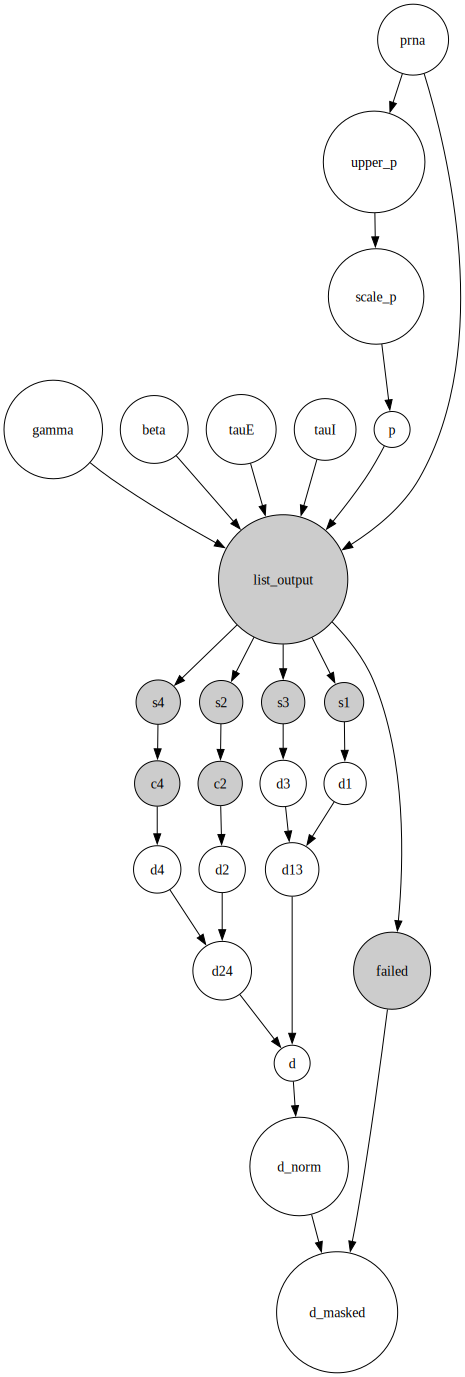

In [36]:
elfi.draw(d)

In [37]:
import GPy

In [38]:
dim = len(m.parameter_names)
kernel = GPy.kern.RBF(input_dim=dim, ARD=True)
# initialise lengthscale parameters and set prior
kernel.lengthscale = 0.2
kernel.lengthscale.set_prior(GPy.priors.Gamma(2, 5), warning=False)
# tauI is expected to have a much larger lengthscale
kernel.lengthscale[[-1]] = 6
kernel.lengthscale[[-1]].set_prior(GPy.priors.Gamma(2, 0.2), warning=False)
kernel = kernel + GPy.kern.Bias(input_dim=dim)

In [ ]:
# reload data for ploting 

In [39]:
def load_model(filename):
    saved = np.load(filename)
    dim = saved['X'].shape[1]

    k = GPy.kern.RBF(input_dim=dim, ARD=True)+ GPy.kern.Bias(input_dim=dim) # need to add bias to match with the dimension
    m = GPy.models.GPRegression(saved['X'], saved['Y'], kernel=k)

    m[:] = saved['params']
    m.parameters_changed()

    return m

In [40]:
loaded_gp = load_model('virology_GPmodel_bolfi_synthetic_n1000_wider_Aug25.npz')

In [41]:
loaded_target_model = elfi.GPyRegression(m.parameter_names, bounds, gp=loaded_gp) # use m.parameter_names, loaded_gp

In [42]:
#target_model = elfi.RobustGPyRegression(m.parameter_names, bounds=bounds, kernel=kernel.copy(), clf_kernel=kernel.copy(), train_classifier=True, thd=0.1)
prior = elfi.model.extensions.ModelPrior(m)
acq = elfi.methods.bo.acquisition.MaxVar(model=loaded_target_model, prior=prior) # replaced with loaded model
bolfi_2 = elfi.BOLFI(d_masked, batch_size=1, initial_evidence=200, update_interval=10, bounds=bounds, acq_noise_var=0.1, seed=seed, target_model=loaded_target_model, acquisition_method=acq) #here replace with loaded model

In [43]:
optim_result = bolfi_2.extract_result()
optim_result.x_min

{'beta': array([-5.91598098]),
 'gamma': array([-0.08187125]),
 'p': array([0.57632006]),
 'prna': array([3.10403802]),
 'tauE': array([6.75223603]),
 'tauI': array([25.51218345])}

In [44]:
bolfi_2.target_model._gp

GP_regression.,value,constraints,priors
sum.rbf.variance,0.8198409983292146,+ve,
sum.rbf.lengthscale,"(6,)",+ve,
sum.bias.variance,2.340268835209562,+ve,
Gaussian_noise.variance,0.003496751856932156,+ve,


In [45]:
bolfi_2.target_model._gp.sum.rbf.lengthscale

index,GP_regression.sum.rbf.lengthscale,constraints,priors
[0],1.51607622,+ve,
[1],1.31929211,+ve,
[2],1.39541133,+ve,
[3],1.94609523,+ve,
[4],7.41808870,+ve,
[5],42.07701337,+ve,


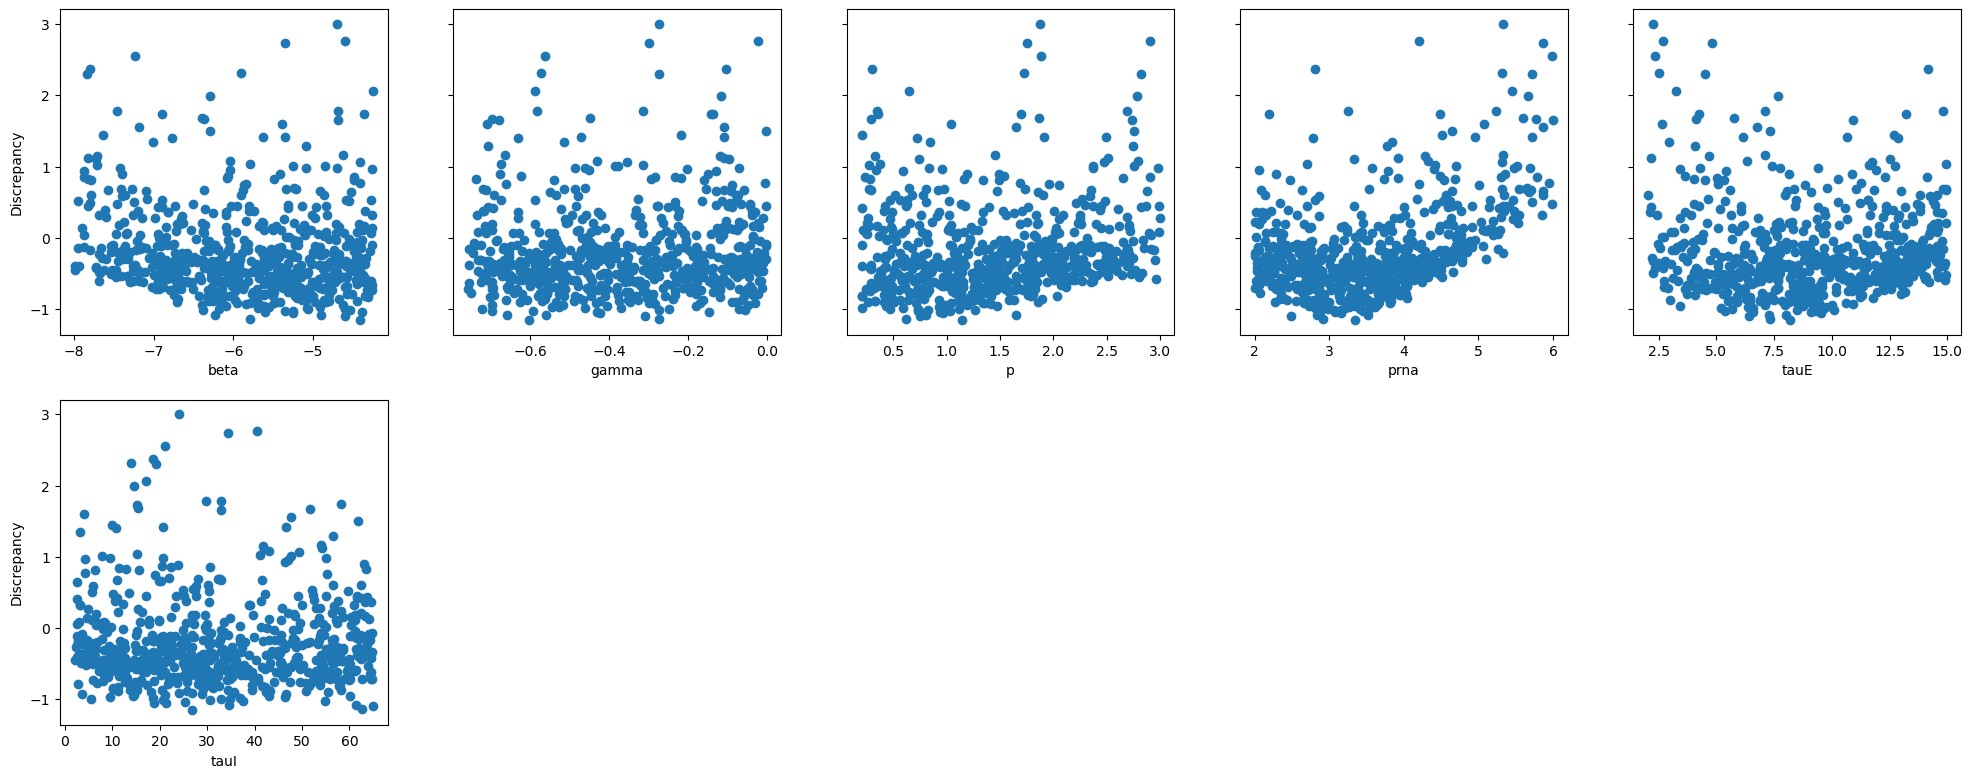

In [46]:
bolfi_2.plot_discrepancy();

In [60]:
def plot_1d_slices(model, cutat, xlim, names=None, plot_data=False):
    dim = xlim.shape[0]
    fig, ax = plt.subplots(1, dim, figsize=(5*dim, 5))
    fixed = [(index, value) for index,value in zip(np.arange(dim), cutat)]
    for active_dim in range(dim):
        not_fixed = fixed.pop(0)
        model.plot(fixed_inputs=fixed, plot_data=plot_data, ax=ax[active_dim])
        ax[active_dim].set_xlim(xlim[active_dim])
        if names is not None: ax[active_dim].set_xlabel(names[active_dim])
        fixed.append(not_fixed)

In [46]:
plt.rc('font', size=22) 

In [50]:
para_true_values

[-5.55, -0.3, 0.66, 3.03, 7, 41]

In [ ]:
para_true_values =[-5.55, -0.3, 0.66, 3.03, 7, 41]

In [62]:
# posterior mean
plot_point_posteriormean=[-5.406, -0.379, 0.913, 3.056, 7.436, 38.522] 

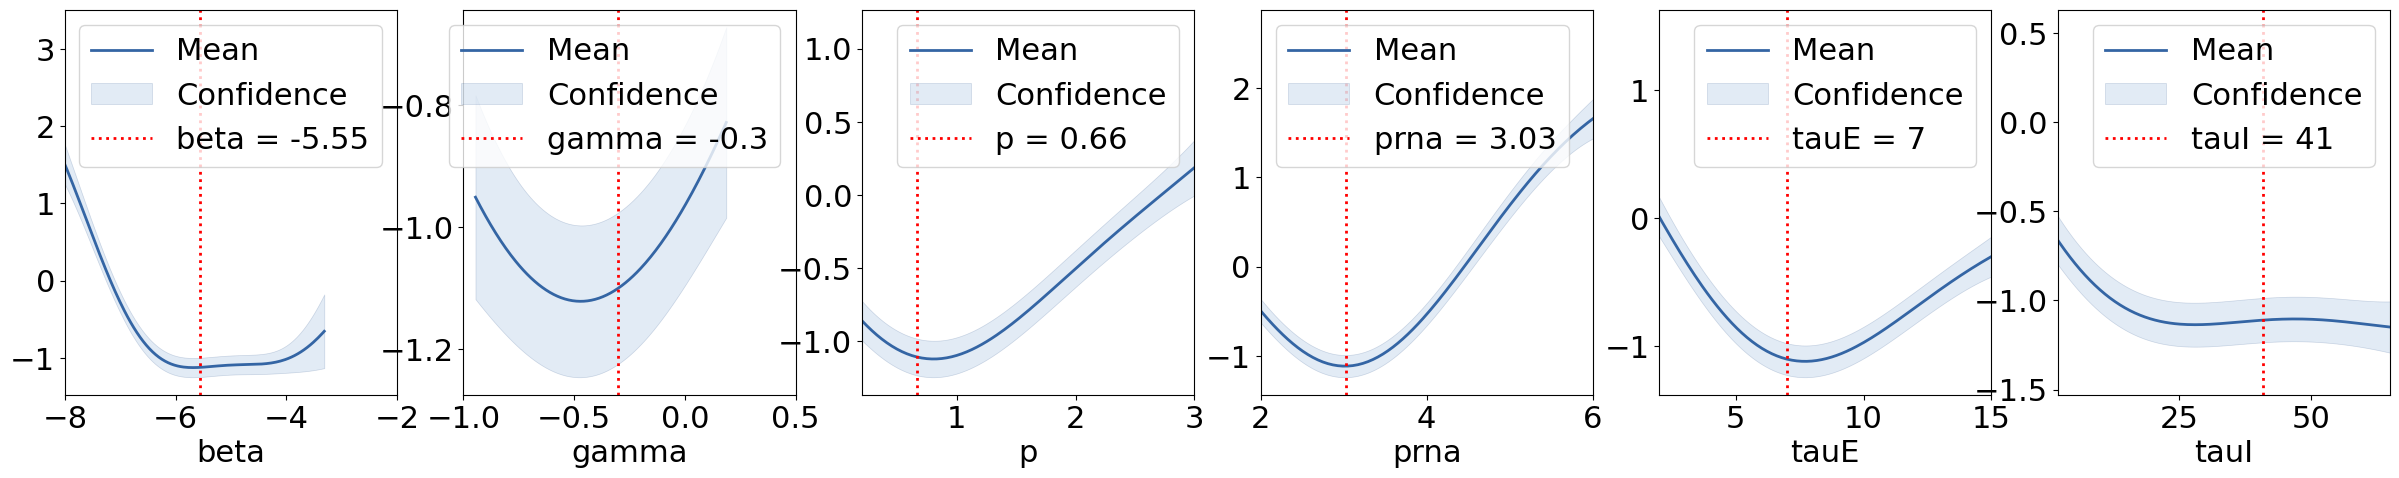

In [53]:
parameter_names = bolfi_2.target_model.parameter_names

# Generate the plot
plot_point = plot_point_posteriormean #### here use the posterior sample mean 

xlim = np.array([bounds[name] for name in m.parameter_names])
plot_1d_slices(bolfi_2.target_model.instance, plot_point, xlim, names=parameter_names)

# Retrieve the axes manually
axes = plt.gcf().get_axes()

# Extract the corresponding values from para_true
para_true_values =[-5.55, -0.3, 0.66, 3.03, 7, 41] # here shortened the values for saving plotting space on figures

# Add the red points to each subplot
for i, ax in enumerate(axes):
    param_value = para_true_values[i]
    #ax.scatter(param_value, 0, color='red', marker='o', label=f"{parameter_names[i]} = {param_value}")
    ax.axvline(param_value, color='red', linestyle=':', linewidth=2, label=f"{parameter_names[i]} = {param_value}")

# Optionally, add a legend to each subplot
for ax in axes:
    ax.legend()

# Show the plot
plt.show()